# `hw3`: Bayesian inference of Oxygen Saturation from Photoplethysmography


Deadline: **Friday, December 13, 11:59 PM**. 
- Submit your completed notebook on your personal Github repository created when accepting the assignment.
- All cells must be executable and their outputs should not be erased before submission.
- Homeworks are carried out *individually*.

In [1]:
# Fill in this cell with your personal details:
# - Name: Yang Lei
# - Student ID: S201670
# - Email: Lei.Yang@student.uliege.be

In this homework, you will have to infer oxygen saturation (SPO2 / SO2) measures from unprocessed photoplethysmography (PPG) using data from the [OpenOximetry Repository](https://physionet.org/content/openox-repo/1.0.1). More precisely, you will build a small probabilistic model of PPG from SpO2, and infer some physical parameters along with the unknown SpO2 from the observed PPG data. See homework 1 for instructions on how to handle the dataset, and homework 2 for instruction on how to prepare the data for inference.

## Oximeter

An [oximeter](https://en.wikipedia.org/wiki/Pulse_oximetry) is a medical device that estimates the **blood oximetry**, or **oxygen saturation** ($\text{SpO2}$), using the two [photoplethysmographs](https://en.wikipedia.org/wiki/Photoplethysmogram) obtained by illuminating the skin at two different wavelengths (red at $\lambda = 660 \text{nm}$ and infrared at $\lambda = 940 \text{nm}$).
Note that the oxygen saturation ($\text{SpO2}$), is defined as the ratio of the concentration of oxygenated hemoglobyn by the total concentration of hemoglobyn,
$$
    \text{SpO2} = \frac{[Hb02]}{[Hb02] + [Hb]}.
$$
The estimation made by the oximeter is based on the difference of light absorption bewteen the oxygenated hemoglobin (HbO2) and deoxygenated hemoglobin (Hb) at two different wavelengths (see details below in the probabilistic model). 

Because many factors alter the absorbance of the light by the skin, it usually assumed that only the **pulsative component** $\text{AC}$ of a cardiac cycle is due to the variation of the blood pressure. The **pulsative component** $\text{AC}(\lambda)$ at a given wavelength $\lambda$ during a cycle that spans from $t=t_1$ to $t=t_2$ is defined as, 
$$
    \text{AC}(\lambda) = \max(\text{PPG}(\lambda)_{t_1:t_2}) - \min(\text{PPG}(\lambda)_{t_1:t_2}),
$$
while the **non pulsative component** $\text{DC}(\lambda)$ at a given wavelength $\lambda$ is defined as,
$$
    \text{DC}(\lambda) = \text{mean}(\text{PPG}(\lambda)_{t_1:t_2}). 
$$
Since the **non pulsative component** is assumed to be mainly caused by other factors (skin color, skin tissues, veins, etc), oximeters usually focus on the **pulsative component**. Accordingly, they consider their observation to be the **ratio** ($R$) of the **pulsative components**, normalized by the **nonpulsative components**, at the two different wavelengths,
$$
    R
    =
    \frac{
        \text{AC}(660 \text{nm})/\text{DC}(660 \text{nm})
    }{
        \text{AC}(940 \text{nm})/\text{DC}(940 \text{nm})
    }.
$$


## Probabilistic Model

In this homework, we assume the following probabilistic model from the oxygen saturation ($\text{SpO2}$) and 5 parameters ($\sigma^2$, $\epsilon_\text{HbO2}(660 \text{nm})$, $\epsilon_\text{Hb}(660 \text{nm})$, $\epsilon_\text{HbO2}(940 \text{nm})$, $\epsilon_\text{HbO2}(940 \text{nm})$) to the observed ratio ($R$).

The Beer-Lambert law state that the absorption of light of a substance in a solution is proportional to its concentration, such that the absorption of the blood at a given wavelength $\lambda$ can be written,
$$
    A(\lambda) = \text{SpO2} \; \epsilon_\text{Hb02}(\lambda) + (1 - \text{SpO2}) \; \epsilon_\text{Hb}(\lambda).
$$

Assuming that the ratio ($R$) of normalized pulsative signals is proportional to the ratio of aborbances at the two wavelengths, we propose the following model, 
$$
    R
    \sim
    \mathcal{N}\left(
        \frac{
            \text{SpO2} \; \epsilon_\text{Hb02}(660 \text{nm}) + (1 - \text{SpO2}) \; \epsilon_\text{Hb}(660 \text{nm})
        }{
            \text{SpO2} \; \epsilon_\text{Hb02}(940 \text{nm}) + (1 - \text{SpO2}) \; \epsilon_\text{Hb}(940 \text{nm})
        },
        \sigma^2
    \right).
$$

The input ($\text{SpO2}$) and the 5 parameters ($\sigma^2$, $\epsilon_\text{HbO2}(660 \text{nm})$, $\epsilon_\text{Hb}(660 \text{nm})$ are unknown. We nevertheless report below some empirical absorption coefficients should help finding good informative priors for these coefficients: [https://omlc.org/spectra/hemoglobin/summary.html](https://omlc.org/spectra/hemoglobin/summary.html).

<div class="alert alert-info">
    
**Information**. We provide the functions `extract_beats` and some empirical absorption coefficients.
    
</div>

In [2]:
import os
import emcee
import corner
import warnings
import wfdb as wf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from scipy.stats import norm, gamma
from scipy.signal import butter, filtfilt, resample, find_peaks

warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
EPS_HBO2_660 = 319.6
EPS_HB_660 = 3226.56

EPS_HBO2_940 = 1214
EPS_HB_940 = 693.44

In [4]:
def extract_beats(ppg, f_ppg, min_time_between=0.4):
    """
    Arguments:
    ----------
    ppg: np.ndarray
        A one dimensional time series of ppg data (red or ir).
    f_ppg: int
        The sampling frequency (Hz).
    min_time_between: float
        The minimal time between two heartbeats.

    Returns:
    --------
    - peaks: np.ndarray
        The indices of the heartbeats peaks in the ppg time series.
    """
    min_number_between = int(min_time_between * f_ppg)
    peaks, _ = find_peaks(ppg, distance=min_number_between)
    return peaks

# Exercises

- Solve the exercises below by making the best use of the API offered in the imported libraries.
- You will also need to use the `wfdb` library for reading and writing waveform data (see [WFDB Documentation](https://wfdb.readthedocs.io/en/latest/wfdb.html)).
- For plots, feel free to use `matplotlib`, `seaborn` or `pandas` built-in plotting functions.
- Follow the data visualization principles as best as possible to make your plots effective and readable.
- For each exercise, add Markdown cells to explain what you are doing and to discuss your results.

<div class="alert alert-info">
    
**Information**. In this homework, we focus on encounter `c5dd95c1ac9fc618cab2e940096089c6a91be58206fa6fc6a1375c69c4922779`. Below, we load the SpO2 data from `f'{encounter_id}_2hz.csv'` (device 59) and the PPG data from `f'{encounter_id}_ppg.dat'`. 
    
</div>

<div class="alert alert-danger">

**Warning**. Note that the PPG recording starts approximately 2.80 min after the SpO2, and it is shifted accordingly.

</div>

In [5]:
encounter_id = "c5dd95c1ac9fc618cab2e940096089c6a91be58206fa6fc6a1375c69c4922779"

In [6]:
f_spo2 = 2

start = 5 * 60

saturation = pd.read_csv(f'data/waveforms/{encounter_id[0]}/{encounter_id}_2hz.csv')
spo2 = saturation['dev59_SpO2'].to_numpy()[start * f_spo2:]
t_spo2 = np.arange(spo2.shape[0]) / (60 * f_spo2)

In [7]:
f_ppg = 86

start = (5 - 2.8) * 60

ppg, ppg_info = wf.rdsamp(f'data/waveforms/{encounter_id[0]}/{encounter_id}_ppg')
ppg = ppg[int(start * f_ppg):]

ir = ppg[:, 0]
red = ppg[:, 1]
t_ppg = np.arange(len(red)) / (60 * f_ppg)

## Part 1: Data Preparation

<div class="alert alert-info">

**Information**. In this part, you should simply reproduce the data preparation steps from Homework 2.

</div>

<div class="alert alert-success">
    
**Exercise** (identical to Homework 2). Using the function `extract_beats`, find all starts of cardiac cycles (the peak of the heart beat) $t_1, t_2, \dots, t_N$ using one of the two PPG signals (red or infrared).
    
For both PPG signals, compute the pulsative component ($\text{AC}(\lambda)$) and non pulsative component ($\text{DC}(\lambda)$) for each heart cycle. Then, compute the ratio $R$ of normalized pulsative components. 

You now have $N$ ratios (one for each cardiac cycle), and $M$ saturation measurements (one every 0.5 second). Resample the ratio $R$ at the same times as the $\text{SpO2}$ time series so that the two time series are paired.

For simplicity, subsample only one every 200 ratios ($R$) and one every 200 oxygen saturation ($\text{SpO2}$).

</div>

In [8]:
peaks = extract_beats(red, f_ppg)

def AC(signal ,peaks):
    ac = np.zeros(len(peaks)-1)
    for i in range (0, len(peaks)-1):
        start = peaks[i]
        end = peaks[i+1]
        ac[i] = np.max(signal[start:end]) - np.min(signal[start:end])
    return ac

def DC(signal ,peaks):
    dc = np.zeros(len(peaks)-1)
    for i in range (0, len(peaks)-1):
        start = peaks[i]
        end = peaks[i+1]
        dc[i] = np.mean(signal[start:end])
    return dc

def R(ac_ir, ac_red, dc_ir, dc_red):
    r = np.zeros(len(ac_ir))
    for i in range(len(ac_ir)):
        r[i] =  (ac_red[i] / dc_red[i])/ (ac_ir[i] / dc_ir[i]) 
    return r

ac_red = AC(red, peaks)
ac_ir = AC(ir, peaks)
dc_red = DC(red, peaks)
dc_ir = DC(ir, peaks)

r = R(ac_ir, ac_red, dc_ir, dc_red)

r_resampled = resample(r, len(spo2))

r_200 = r_resampled[::200]
spo2_200 = spo2[::200]
t_200 = t_spo2[::200]

<div class="alert alert-success">
    
**Exercise** (identical to Homework 2). Write a `sample_likelihood` function that takes as arguments an array $\text{SpO2}_{1:T}$ of $T$ oxygen saturation measurements (caution, it is expressed in %), along with the 5 parameters ($\sigma^2$, $\epsilon_\text{HbO2}(660nm)$, $\epsilon_\text{Hb}(660nm)$, $\epsilon_\text{HbO2}(940nm)$, $\epsilon_\text{HbO2}(940nm)$), and that returns $n$ realisation of the ratio $R$ for each of the $T$ inputs. You are free to choose any alternate parametrization for the parameters.

Write a `log_likelihood` function that takes the same arguments as `sample_likelihood`, along with a ratio ($R$), and returns the log likelihood of this ratio according to the probabilistic model.

</div>

In [9]:
def meanR(SpO2, parameters):
    ePS_HBO2_660, ePS_HB_660, ePS_HBO2_940, ePS_HB_940 = parameters
    num = SpO2 * ePS_HBO2_660 + (1 - SpO2) * ePS_HB_660
    den = SpO2 * ePS_HBO2_940 + (1 - SpO2) * ePS_HB_940
    return num / den

def sample_likelihood(parameters, n= 1):
    sigma_square,ePS_HBO2_660, ePS_HB_660, ePS_HBO2_940, ePS_HB_940= parameters [:5]
    SpO2  = parameters[5:]
    SpO2_norm = SpO2 /100
    r_mean = meanR(SpO2_norm, [ePS_HBO2_660, ePS_HB_660, ePS_HBO2_940, ePS_HB_940])
    return np.random.normal(loc=r_mean, scale=np.sqrt(sigma_square), size=(n, len(SpO2)))
    
def log_likelihood(parameters, r):
    sigma_square,ePS_HBO2_660, ePS_HB_660, ePS_HBO2_940, ePS_HB_940= parameters [:5]
    SpO2  = parameters[5:]
    SpO2_norm = SpO2 /100
    r_mean = meanR(SpO2_norm, [ePS_HBO2_660, ePS_HB_660, ePS_HBO2_940, ePS_HB_940])
    return np.sum(norm.logpdf(r,loc = r_mean,scale=np.sqrt(sigma_square)))


## Part 2: Inference

<div class="alert alert-info">

**Information**. We will now consider a fully Bayesian model where both the input ($\text{SpO2}$) and the 5 parameters ($\sigma^2$, $\epsilon_\text{HbO2}(660 \text{nm})$, $\epsilon_\text{Hb}(660 \text{nm})$, $\epsilon_\text{HbO2}(940 \text{nm})$, $\epsilon_\text{HbO2}(940 \text{nm})$) also become random variables with their own priors.

</div>

<div class="alert alert-success">
    
**Exercise**. Write the mathematical expression of the joint density,
$$
    p(R, \text{SpO2}, \sigma^2, \epsilon_\text{HbO2}(660 \text{nm}), \epsilon_\text{Hb}(660 \text{nm}), \epsilon_\text{HbO2}(940 \text{nm}), \epsilon_\text{HbO2}(940 \text{nm})).
$$
    
</div>

We are going to start from this : 

$$
    p(R, \text{SpO2}, \sigma^2, \epsilon_\text{HbO2}(660 \text{nm}), \epsilon_\text{Hb}(660 \text{nm}), \epsilon_\text{HbO2}(940 \text{nm}), \epsilon_\text{HbO2}(940 \text{nm})).
$$

The likelihood is :

$$
    p(R |\text{SpO2} , \sigma^2, \epsilon_\text{HbO2}(660 \text{nm}), \epsilon_\text{Hb}(660 \text{nm}), \epsilon_\text{HbO2}(940 \text{nm}), \epsilon_\text{HbO2}(940 \text{nm})).
$$

We assume that each parameters is independents of each other so the prior is:

$$
    p(\text{SpO2} , \sigma^2, \epsilon_\text{HbO2}(660 \text{nm}), \epsilon_\text{Hb}(660 \text{nm}), \epsilon_\text{HbO2}(940 \text{nm}), \epsilon_\text{HbO2}(940 \text{nm})).
$$

=
$$
    p(\text{SpO2})* p(\sigma^2) * p(\epsilon_\text{HbO2}(660 \text{nm}))* p(\epsilon_\text{Hb}(660 \text{nm}))* p(\epsilon_\text{HbO2}(940 \text{nm}))* p(\epsilon_\text{HbO2}(940 \text{nm})).
$$

So the final expression is : 

$$
    p(R, \text{SpO2}, \sigma^2, \epsilon_\text{HbO2}(660 \text{nm}), \epsilon_\text{Hb}(660 \text{nm}), \epsilon_\text{HbO2}(940 \text{nm}), \epsilon_\text{HbO2}(940 \text{nm})).
$$ 

= 

$$
    p(R |\text{SpO2} , \sigma^2, \epsilon_\text{HbO2}(660 \text{nm}), \epsilon_\text{Hb}(660 \text{nm}), \epsilon_\text{HbO2}(940 \text{nm}), \epsilon_\text{HbO2}(940 \text{nm})) * p(\text{SpO2})* p(\sigma^2)
    
    *
$$

$$
p(\epsilon_\text{HbO2}(660 \text{nm}))* p(\epsilon_\text{Hb}(660 \text{nm}))* p(\epsilon_\text{HbO2}(940 \text{nm}))* p(\epsilon_\text{HbO2}(940 \text{nm}))
$$

<div class="alert alert-success">
    
**Exercise**. Select and discuss some prior distribution for both the input ($\text{SpO2}$) and the 5 parameters ($\sigma^2$, $\epsilon_\text{HbO2}(660 \text{nm})$, $\epsilon_\text{Hb}(660 \text{nm})$, $\epsilon_\text{HbO2}(940 \text{nm})$, $\epsilon_\text{HbO2}(940 \text{nm})$).  Write a `sample_prior` function that returns samples from this prior distribution. Write a `log_prior` that returns the log probability of inputs and parameters. Finally, write a `sample_joint` function that returns samples from the joint distribution over input, parameters and ratios.
    
</div>

In [ ]:
from scipy.stats import uniform,norm,beta

def sample_prior(n):
    sigma_square = uniform(1e-8, 10 ).rvs(n)
    ePS_HBO2_660 = norm(EPS_HBO2_660, 100).rvs(n)
    ePS_HB_660 = norm(EPS_HB_660, 100).rvs(n)
    ePS_HBO2_940 = norm(EPS_HBO2_940, 100).rvs(n)
    ePS_HB_940 = norm(EPS_HB_940, 100).rvs(n)
    SpO2 = uniform(-100, 200).rvs(size=(n, 30)) 

    return np.column_stack([sigma_square, ePS_HBO2_660, ePS_HB_660, ePS_HBO2_940, ePS_HB_940, SpO2])
def sample_prior2(n):
    sigma_square = uniform(1e-8, 0.2).rvs(n)
    ePS_HBO2_660 = norm(EPS_HBO2_660, 100).rvs(n)
    ePS_HB_660 = norm(EPS_HB_660, 100).rvs(n)
    ePS_HBO2_940 = norm(EPS_HBO2_940, 100).rvs(n)
    ePS_HB_940 = norm(EPS_HB_940, 100).rvs(n)
    SpO2 = beta(8, 2).rvs(size=(n, 30)) * 100

    return np.column_stack([sigma_square, ePS_HBO2_660, ePS_HB_660, ePS_HBO2_940, ePS_HB_940, SpO2])
def sample_prior3(n):
    sigma_square = uniform(1e-8,10).rvs(n)
    ePS_HBO2_660 = uniform(EPS_HBO2_660-200, 400).rvs(n)
    ePS_HB_660 = uniform(EPS_HB_660-200, 400).rvs(n)
    ePS_HBO2_940 = uniform(EPS_HBO2_940-200, 400).rvs(n)
    ePS_HB_940 = uniform(EPS_HB_940-200, 400).rvs(n)
    SpO2 = uniform(-100, 200).rvs(size=(n, 30)) 

    return np.column_stack([sigma_square, ePS_HBO2_660, ePS_HB_660, ePS_HBO2_940, ePS_HB_940, SpO2])

def sample_prior4(n):
    sigma_square = uniform(1e-8, 1).rvs(n)
    ePS_HBO2_660 = norm(EPS_HBO2_660, 100).rvs(n)
    ePS_HB_660 = norm(EPS_HB_660, 100).rvs(n)
    ePS_HBO2_940 = norm(EPS_HBO2_940, 100).rvs(n)
    ePS_HB_940 = norm(EPS_HB_940, 100).rvs(n)
    SpO2 = beta(8, 2).rvs(size=(n, 30)) *100

    return np.column_stack([sigma_square, ePS_HBO2_660, ePS_HB_660, ePS_HBO2_940, ePS_HB_940, SpO2])
def sample_prior5(n):
    sigma_square = uniform(1e-8, 0.2).rvs(n)
    ePS_HBO2_660 = norm(EPS_HBO2_660, 100).rvs(n)
    ePS_HB_660 = norm(EPS_HB_660, 100).rvs(n)
    ePS_HBO2_940 = norm(EPS_HBO2_940, 100).rvs(n)
    ePS_HB_940 = norm(EPS_HB_940, 100).rvs(n)
    SpO2 = uniform(0, 100).rvs(size=(n, 30)) 

    return np.column_stack([sigma_square, ePS_HBO2_660, ePS_HB_660, ePS_HBO2_940, ePS_HB_940, SpO2])
def sample_joint(n,prior):
    parameters = prior(n)
    r_sample = []
    for i in range(n):
        r = sample_likelihood(parameters[i], 1)
        r_sample.append(r)
    r_sample = np.array(r_sample)
    r_sample = r_sample.squeeze(axis=1)
    return parameters, r_sample

def log_prior(parameters):
    sigma_square = parameters[0]
    ePS_HBO2_660 = parameters[1]
    ePS_HB_660 = parameters[2]
    ePS_HBO2_940 = parameters[3]
    ePS_HB_940 = parameters[4]
    SpO2_scale = parameters[5:]/100
    log_sigma_square = uniform.logpdf(sigma_square, 1e-8, 0.2)
    log_ePS_HBO2_660 = norm.logpdf(ePS_HBO2_660,loc =EPS_HBO2_660,scale=100)
    log_ePS_HB_660 = norm.logpdf(ePS_HB_660,loc = EPS_HB_660,scale=100)
    log_ePS_HBO2_940 = norm.logpdf(ePS_HBO2_940,loc= EPS_HBO2_940,scale =100)
    log_ePS_HB_940 = norm.logpdf(ePS_HB_940,loc = EPS_HB_940,scale =100)
    SpO2_clip = np.clip(SpO2_scale, 1e-8, 1 - 1e-8)
    log_SpO2 = np.sum(beta.logpdf(SpO2_clip, 8, 2))


    return log_sigma_square + log_ePS_HBO2_660 + log_ePS_HB_660 + log_ePS_HBO2_940 + log_ePS_HB_940 + log_SpO2

initial_sigma_square = 0.1
initial_parameters = np.concatenate([np.array([initial_sigma_square, EPS_HBO2_660, EPS_HB_660, EPS_HBO2_940, EPS_HB_940]), spo2_200])
print( log_prior(initial_parameters))



-12.628755313051183


I define several different priors and in the following question, I say why I chose the sample prior 2 to define the log prior with the help of the prior predictive check.

In the log_prior function I do a np.clip because python has trouble with the 1 except the beta function is well defined between [0,1] so I approximate 1 because an approximate value

<div class="alert alert-success">
    
**Exercise**. Adjust and discuss your final choice of priors $p(\text{SpO2})$, $p(\sigma^2)$, $p(\epsilon_\text{HbO2}(660 \text{nm}))$, $p(\epsilon_\text{Hb}(660 \text{nm}))$, $p(\epsilon_\text{HbO2}(940 \text{nm}))$, $p(\epsilon_\text{HbO2}(940 \text{nm}))$ through prior predictive checks of $R$.
    
</div>

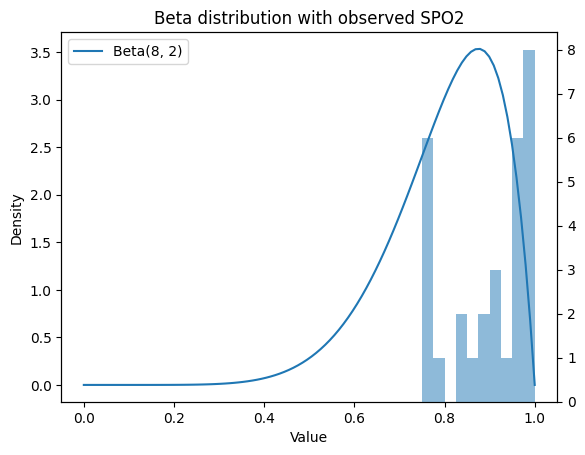

In [120]:
beta_position = np.linspace(0, 1, 100)

fig = plt.figure()
axe = plt.axes()
axe.plot(beta_position, beta.pdf(beta_position, 8, 2), label='Beta(8, 2)')
axe.set_ylabel("Density")
axe.set_xlabel("Value")
ax2 = axe.twinx()
ax2.hist(spo2_200/100, alpha=0.5, label='Samples')
axe.set_title('Beta distribution with observed SPO2')
axe.legend()
plt.show()


We can see here the distribution beta with parameters 8,2 is not a bad approximation of what happens in the observed SPO2 distribution

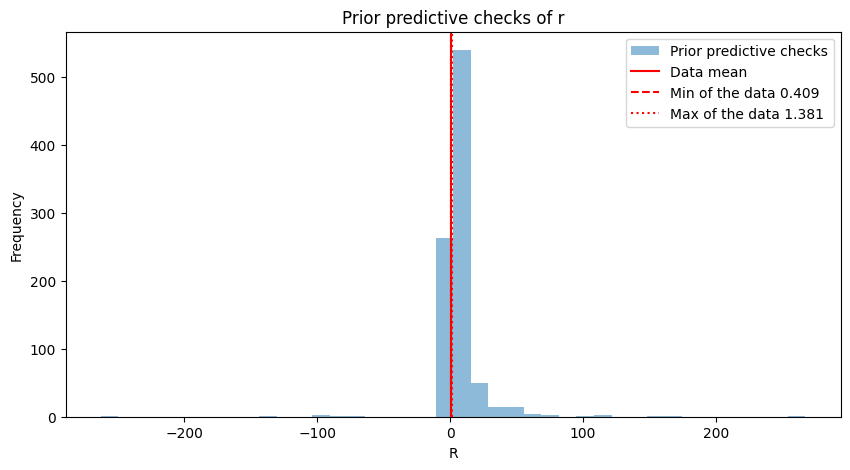

In [11]:
# Justify the choice of the prior with prior predictive checks of R 

_,r_prior = sample_joint(30,sample_prior)
def display_predictive_prior(prior,r_200):
    fig = plt.figure(figsize=(10, 5))
    ax = plt.axes()
    data = prior.flatten()
    ax.hist(data, bins=40, alpha=0.5, label='Prior predictive checks')

    ax.axvline(r_200.mean(), color='red', label='Data mean')
    ax.axvline(r_200.min(), color='red', label= f'Min of the data {r_200.min():.3f}', linestyle='--')
    ax.axvline(r_200.max(), color='red', label=f'Max of the data {r_200.max():.3f}' , linestyle='dotted')
    ax.set_xlabel('R')
    ax.set_ylabel('Frequency')
    ax.set_title('Prior predictive checks of r')
    ax.legend()
    plt.show()
display_predictive_prior(r_prior,r_200)



We can see that with random realizations this prior gives results that sometimes give in the expected values ​​but also give inexplicable values ​​with large or small values. We can reduce the scope of our prior and test another prior

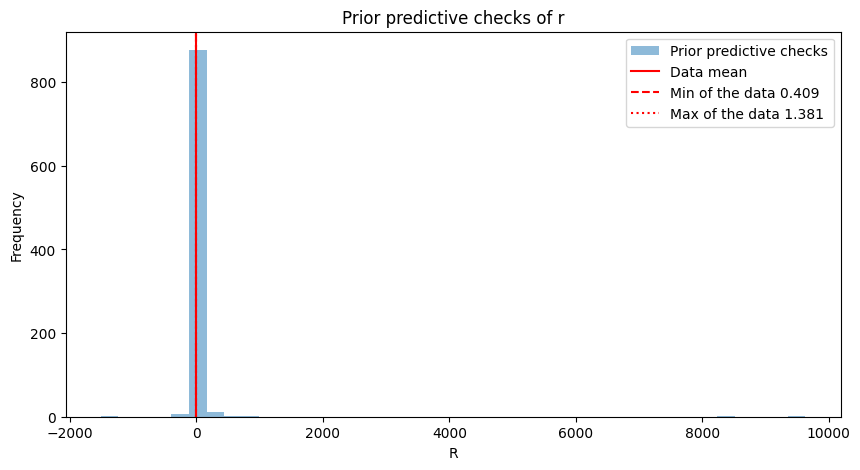

In [12]:
_,r_prior3 = sample_joint(30,sample_prior3)
display_predictive_prior(r_prior3,r_200)

I try to change the distribution of epsilons from normal to uniform and we see that the result is no better or worse so that is not the problem

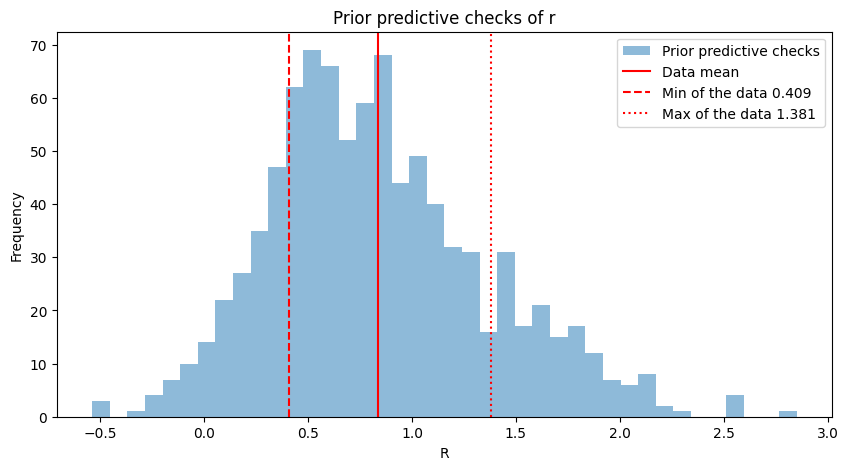

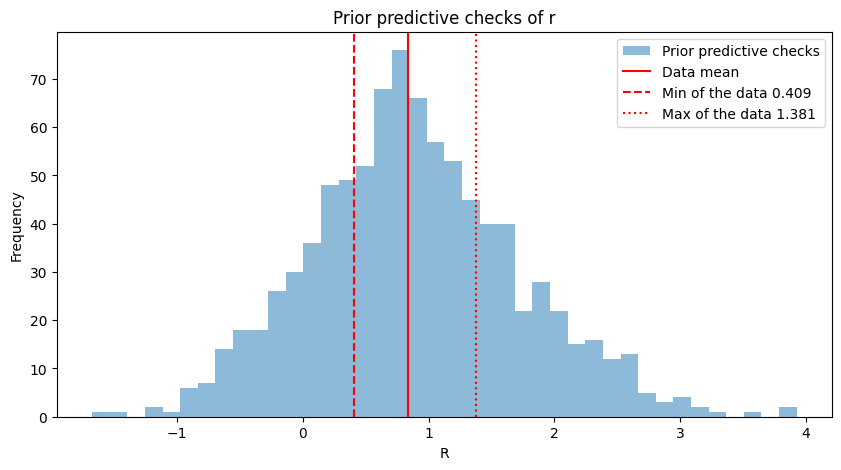

In [13]:
_,r_prior2 = sample_joint(30,sample_prior2)
_,r_prior4 = sample_joint(30,sample_prior4)
display_predictive_prior(r_prior2,r_200)
display_predictive_prior(r_prior4,r_200)

Here there are several changes that we will look at first for the SpO2 we will change the distribution of the priors from what we think to a beta function of parameters 8.2 in order to have our curve close to 1 and after the difference between the first and the second it is the range of the variance that changes. The 2 priors are quite good in the prediction zone but I decided to take number 2 because there is still uncertainty but not too much.

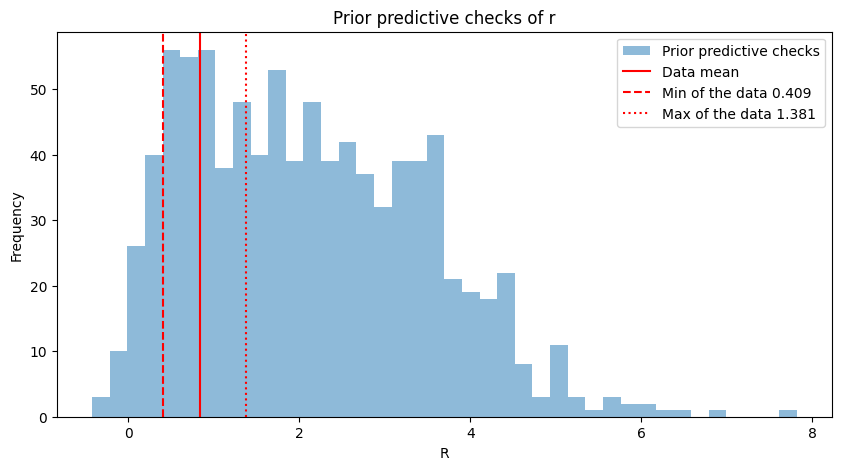

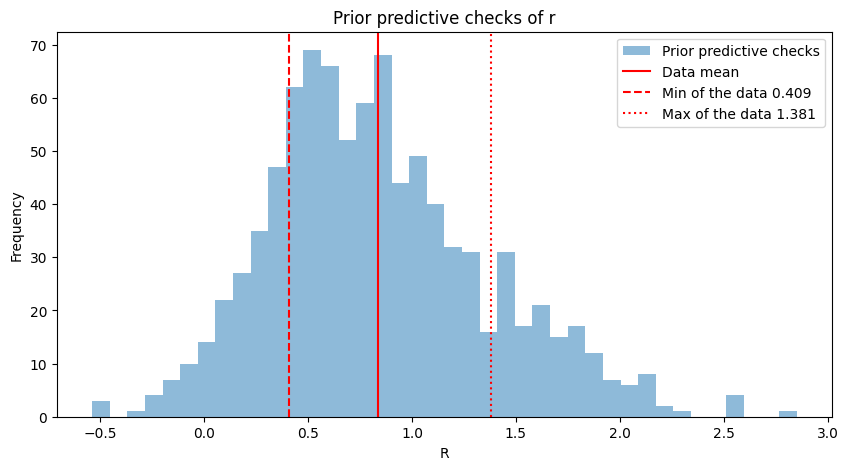

In [14]:
_,r_prior5 = sample_joint(30,sample_prior5)

display_predictive_prior(r_prior5,r_200)
display_predictive_prior(r_prior2,r_200)

Finally I looked at the distribution with a uniform for the SPO2 but this time with the range between 0 and 100 because it is what is logical for a human 100 = human in perfect shape and 0 = dead. We can see that with these changes we are no longer going into the negatives but the range of predict value is still too big

<div class="alert alert-success">
    
**Exercise**. Write a `log_posterior` function that returns the logarithm of the (unormalized) posterior probability density function,
$$
    p(\text{SpO2}_{1:T}, \sigma^2, \epsilon_\text{HbO2}(660 \text{nm}), \epsilon_\text{Hb}(660 \text{nm}), \epsilon_\text{HbO2}(940 \text{nm}), \epsilon_\text{HbO2}(940 \text{nm}) \mid R_{1:T}),
$$
using your previously defined priors.
    
</div>

In [15]:
def log_posterior(parameters, r):
    if np.any(parameters <= 0):
        return -np.inf
    return log_likelihood(parameters, r) + log_prior(parameters)

<div class="alert alert-success">
    
**Exercise**. Use MCMC to compute the posterior distribution given the observed ratios $R_{1:T}$. The posterior distribution is computed on $5$ parameters and $T$ $\text{SpO2}$ values, where $T$ is the number of ratios you subsampled in the time series of ratios.

</div>

In [60]:
import pickle
filename = "sampler.pkl"
initial_parameters = np.concatenate([np.array([0.1, EPS_HBO2_660,EPS_HB_660,EPS_HBO2_940,EPS_HB_940]), spo2_200])
pos = initial_parameters + 0.1*np.random.randn(100, 35)
pos = np.abs(pos)

nwalkers, ndim = pos.shape
print(nwalkers, ndim)
if (not os.path.exists(os.path.join(os.getcwd(), filename))):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(r_200,))
    sampler.run_mcmc(pos, 25000000//nwalkers, progress=True)
    with open(filename, "wb") as f:
        pickle.dump(sampler, f)
else:
    with open(filename, "rb") as f:
        sampler = pickle.load(f)


100 35


To avoid running the code which can last 4 hours with the size of (7GB) then it loads the file which is local or does it if it is not there there is also the chain.py file to run it in parallel and save time too

<div class="alert alert-success">
    
**Exercise**. Plot the resulting Markov chains for the parameters and for some input oximetry $\text{SpO2}$ and discuss their convergence in view of your choice of parametrization and choices of prior distributions. Discuss the mixing, agreement and auto-correlation of the Markov chains.
    
</div>

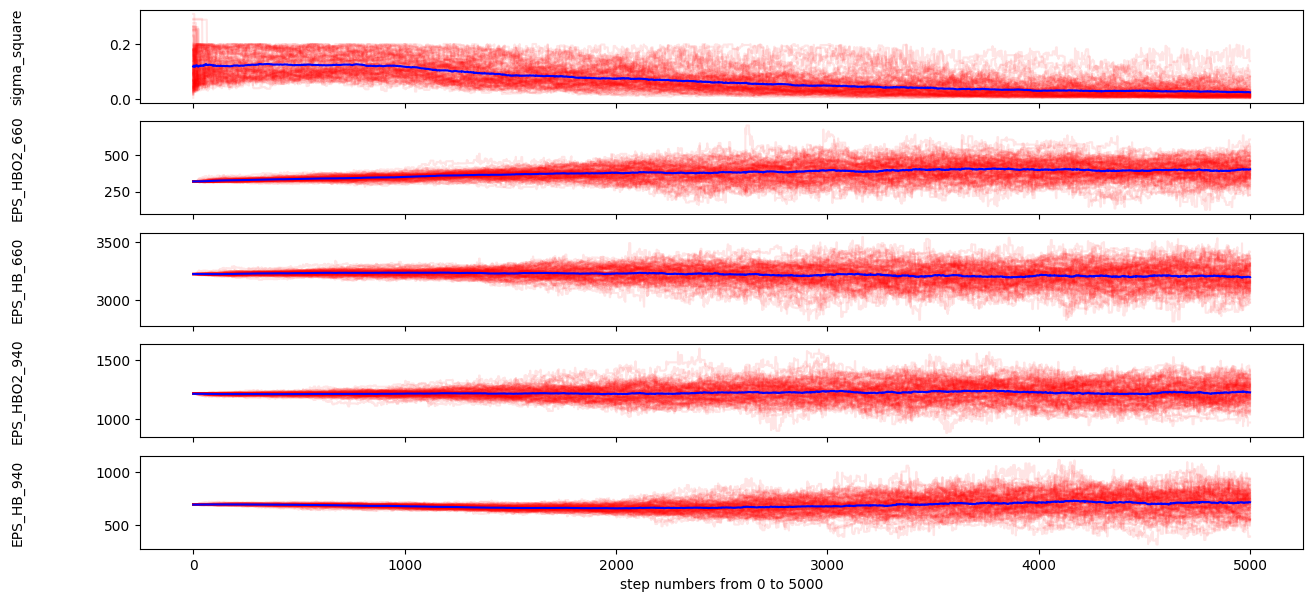

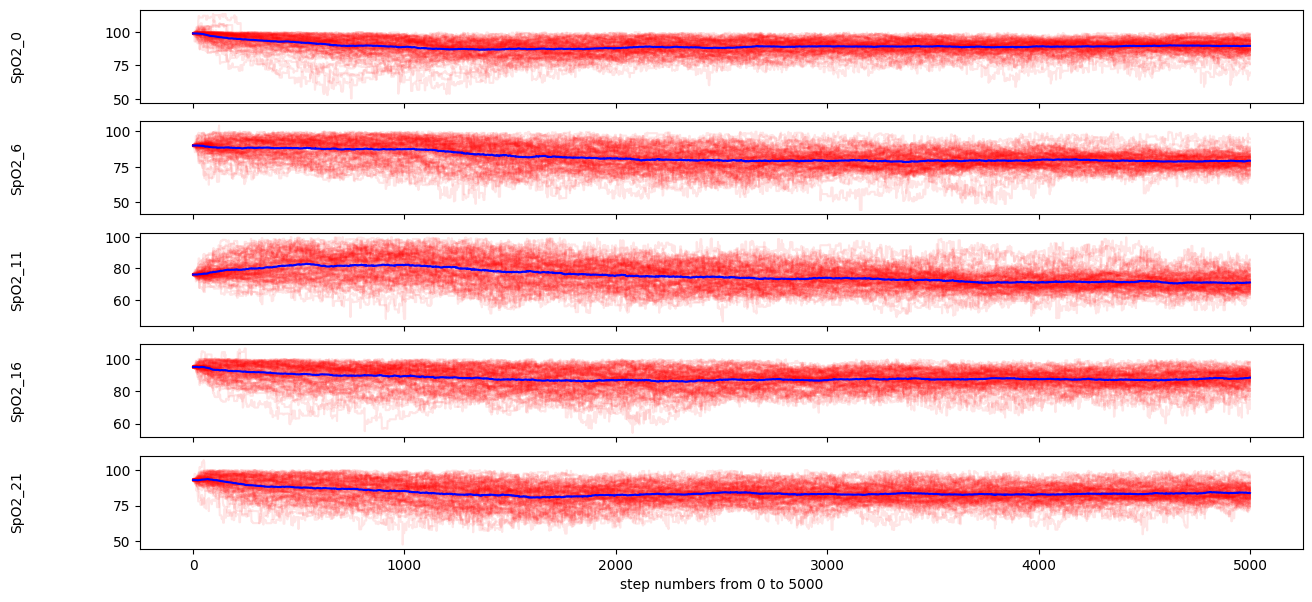

In [58]:
def display_markov_chain(sampler,labels,start,end,offset):
    samples = sampler.get_chain()
    fig, axes = plt.subplots(len(offset), figsize=(15, 7), sharex=True)
    for i in range(len(offset)):
        ax = axes[i]
        index = offset[i]
        ax.plot(samples[start:end, :, index], "r", alpha=0.1)
        ax.plot(np.mean(samples[start:end, :, index], axis=1), "b", alpha=1.0)
        ax.set_ylabel(labels[index])
        ax.yaxis.set_label_coords(-0.1, 0.5)
    axes[-1].set_xlabel(f'step numbers from {start} to {end}')
    plt.show()


labels = ["sigma_square", "EPS_HBO2_660", "EPS_HB_660", "EPS_HBO2_940", "EPS_HB_940"] + [f"SpO2_{i}" for i in range(30)]
display_markov_chain(sampler,labels,0,5000,[0,1,2,3,4])
display_markov_chain(sampler,labels,0,5000,[5,11,16,21,26])


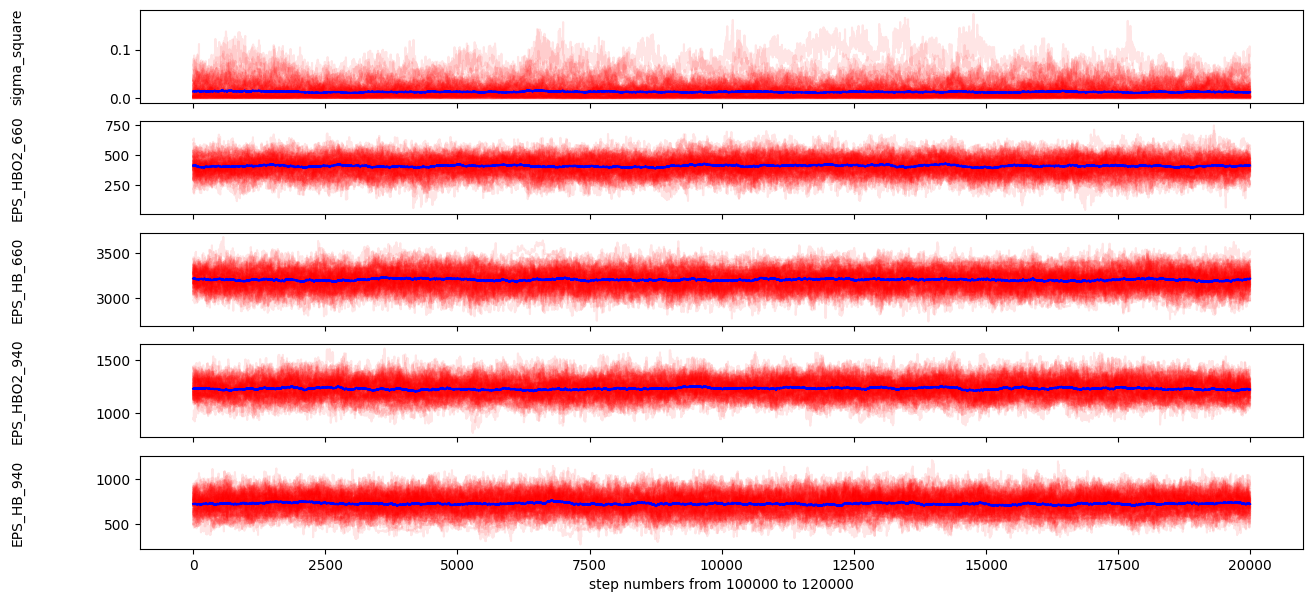

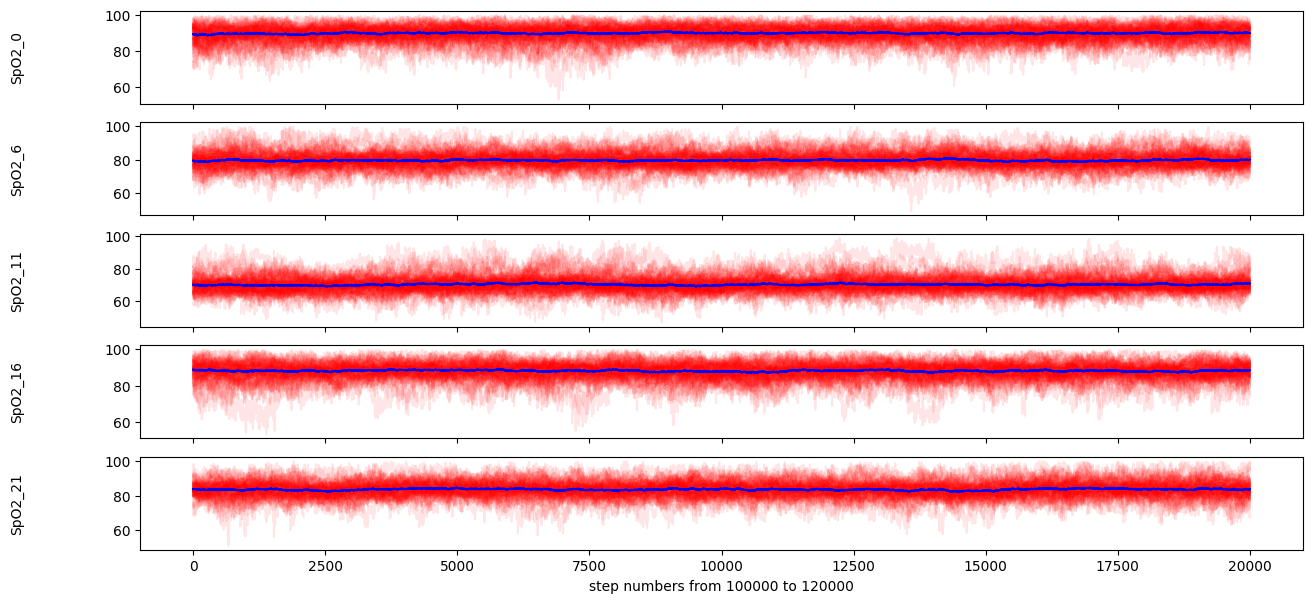

In [116]:
display_markov_chain(sampler,labels,100000,120000,[0,1,2,3,4])
display_markov_chain(sampler,labels,100000,120000,[5,11,16,21,26])

Convergence :

For the sigma_square. The first guess is at the mean of the uniform distribution and let's the mcmc run to see what's going on. We can see that will converge into smaller values less than the mean of uniform distribution.
We can see in the beginning of the chain of Markov it will stay near the initial value for the epsilon and after it they will explore more values but stay around the initial value.
And for the SpO2 they will stay around the initial value for the SpO2 and are going to explore more values. 

For all the parameters and inputs they will converge into estimated posterior probability distributions.

Agreement : 

When we are going to look after the realisations of the different chains, we will see there not a chain who will converge into a another distribution when the number of steps is high so the stationary probability distribution will converge into just a single place.

Mixing : 

We can say that the chain will explore the range of the parameters and we can see that will take some times to explore it and we can see that some chains will explore more than other chains so for the mixing this is not the best one. In the case of the sigma_square we can see that the mixing it not optimal.

In [19]:
tau = sampler.get_autocorr_time()
tau

array([2887.38359335, 1208.77192035, 1155.89608767, 1145.85219551,
       1179.17894239, 1227.53840095, 1187.11860155, 1235.28741789,
       1196.2380894 , 1183.8704638 , 1198.5744215 , 1259.26221617,
       1290.74865593, 1335.08354336, 1435.55584997, 1368.08184997,
       1422.22685428, 1240.66914416, 1234.87821947, 1228.3132001 ,
       1184.20377471, 1167.89036665, 1133.27016115, 1179.73742296,
       1146.29887646, 1261.79944211, 1191.64519674, 1308.17948467,
       1272.25258774, 1331.49155   , 1381.04511423, 1410.85891685,
       1369.29535082, 1399.03607703, 1649.97311043])

Autocorrelation :

When we run markov chains we are going to have a dependency on the state by the previous state much as $(P x_{t} | P x_{t-1}, P x_{t-2},...)$ but in context we don't want to have a dependency on the state by the previous state and having $\exists$ r such that the dependency don't exist $(P x_{t} | P x_{r})$ = 0

For finding this value, we have a function to help us to determine it .get_autocorr_time() which will return for all the parameters the time need to have not dependency. The maximum value is 2887.38 so the minimum value is 2888.

Having this large number will show why the mixing of the Sigma_square is not good enough because the time needs it is very long.



<div class="alert alert-success">
    
**Exercise**. Plot the estimated posterior probability distribution of the parameters and discuss these results.
    
</div>

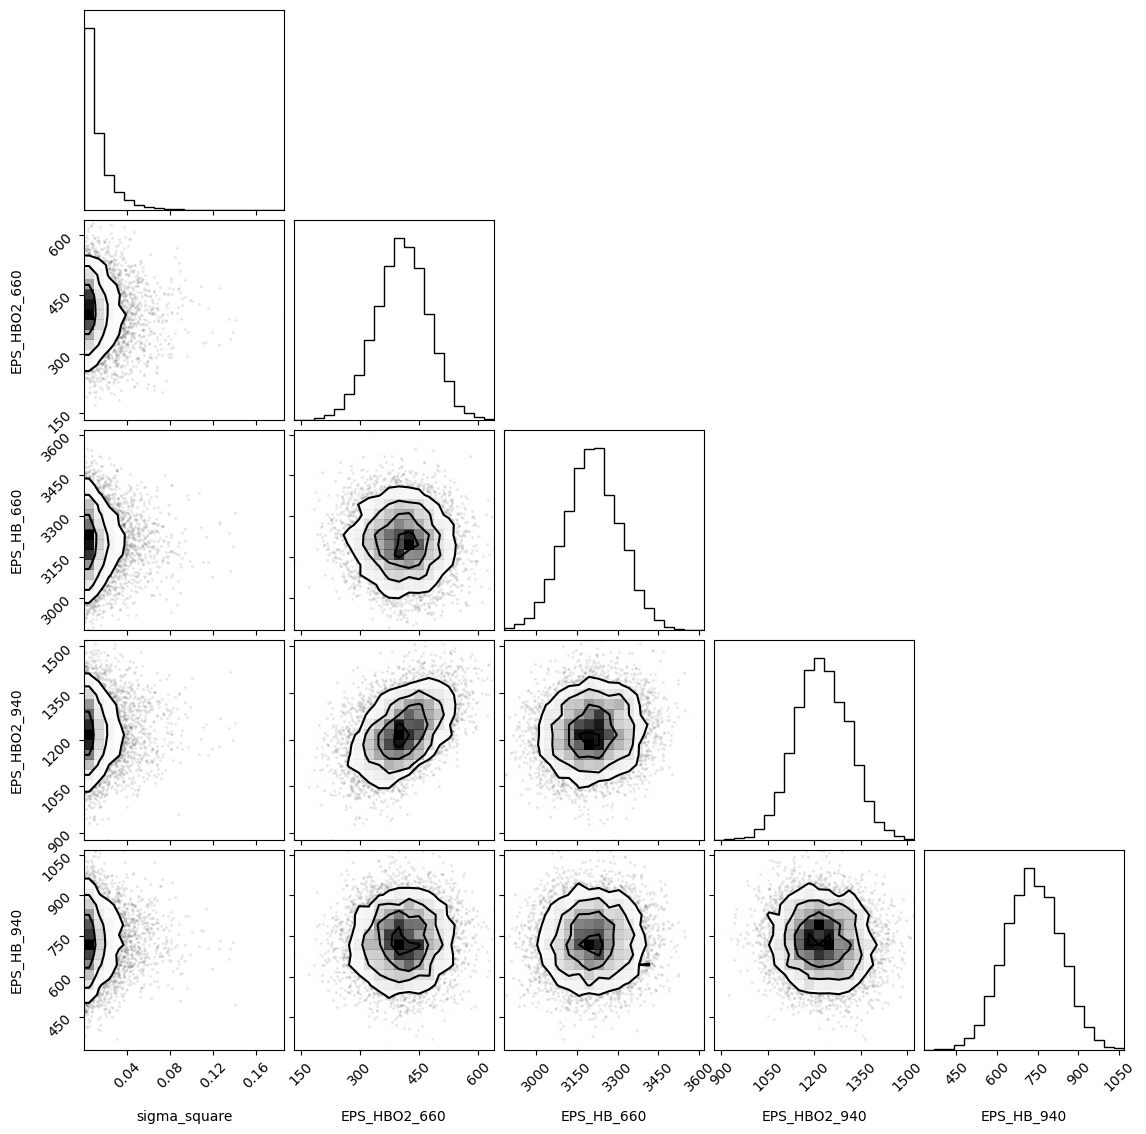

In [ ]:
import corner

flat_samples = sampler.get_chain(discard=40000, thin=3000, flat=True)
params_samples = flat_samples[:,:5]

fig = corner.corner(params_samples, labels=labels[:5])
plt.show()

In the diagonals we have the estimated posterior probability distribution of the parameters. We can see for the epsilons they will follow again a normal distribution. We can expect that because the prior was a normal distribution. And they are wide because of the incertitudes.

For the sigma_square the prior distribution has been removed to replace it into a gamma distribution with probably a very small k and a high theta. It will be caused by the sigma_square can't be negative for the normal distribution 

In the outside of the diagonals , we are going to have the joint distribution of the parameters it will indicate all the combinations where the parameters can explain the data,for each sigma_square, we are going to have semi potatoes by the fact the is a gamma distribution.

And for the rest we are going to have our potatoes. But we can see that EPS_HBO2_660 and EPS_HBO2_940 are a potatoe with a deformation into a positive correlation when one parameter increase the others will tend to increase too.

## Part 3: Criticize

<div class="alert alert-success">
    
**Exercise**. Plot the estimated posterior probability distribution of the oximetry ($\text{SpO2}$).
First, display this posterior probability distribution throughout the subsampled time series of input oximetry $R_{1:T}$, and compare it to the observed oximetry $\text{SpO2}_{1:T}$. Then, ignore the temporal aspect and display the marginal posterior probability distribution of oximetry, along with the marginal observed distribution of oximetry ($\text{SpO2}$). Discuss the results.
    
</div>

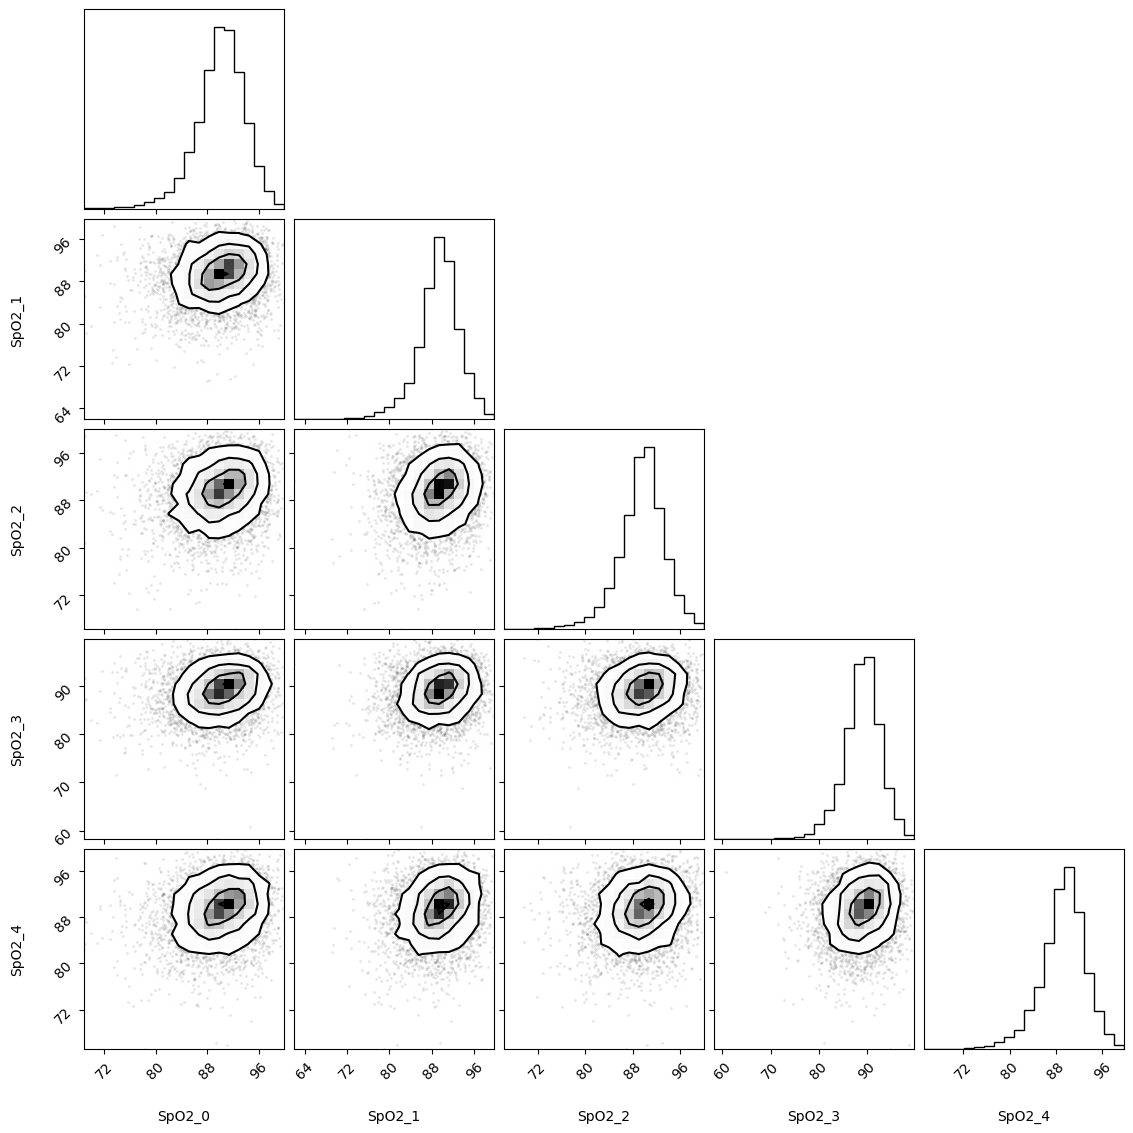

In [126]:
params_samples = flat_samples[:,5:10]

fig = corner.corner(params_samples, labels=labels[5:10])
plt.show()


In the diagonals we have the estimated posterior probability distribution of the inputs. We can see for the SpO2 they will follow again a beta distribution. We can expect that because the prior was a beta distribution. 

In the outside of the diagonals , we are going to have the joint distribution of the parameters it will indicate all the combinations where the parameters can explain the data,we can see the inputs are a potatoe with a deformation into a positive correlation when one parameter increase the others will tend to increase too.

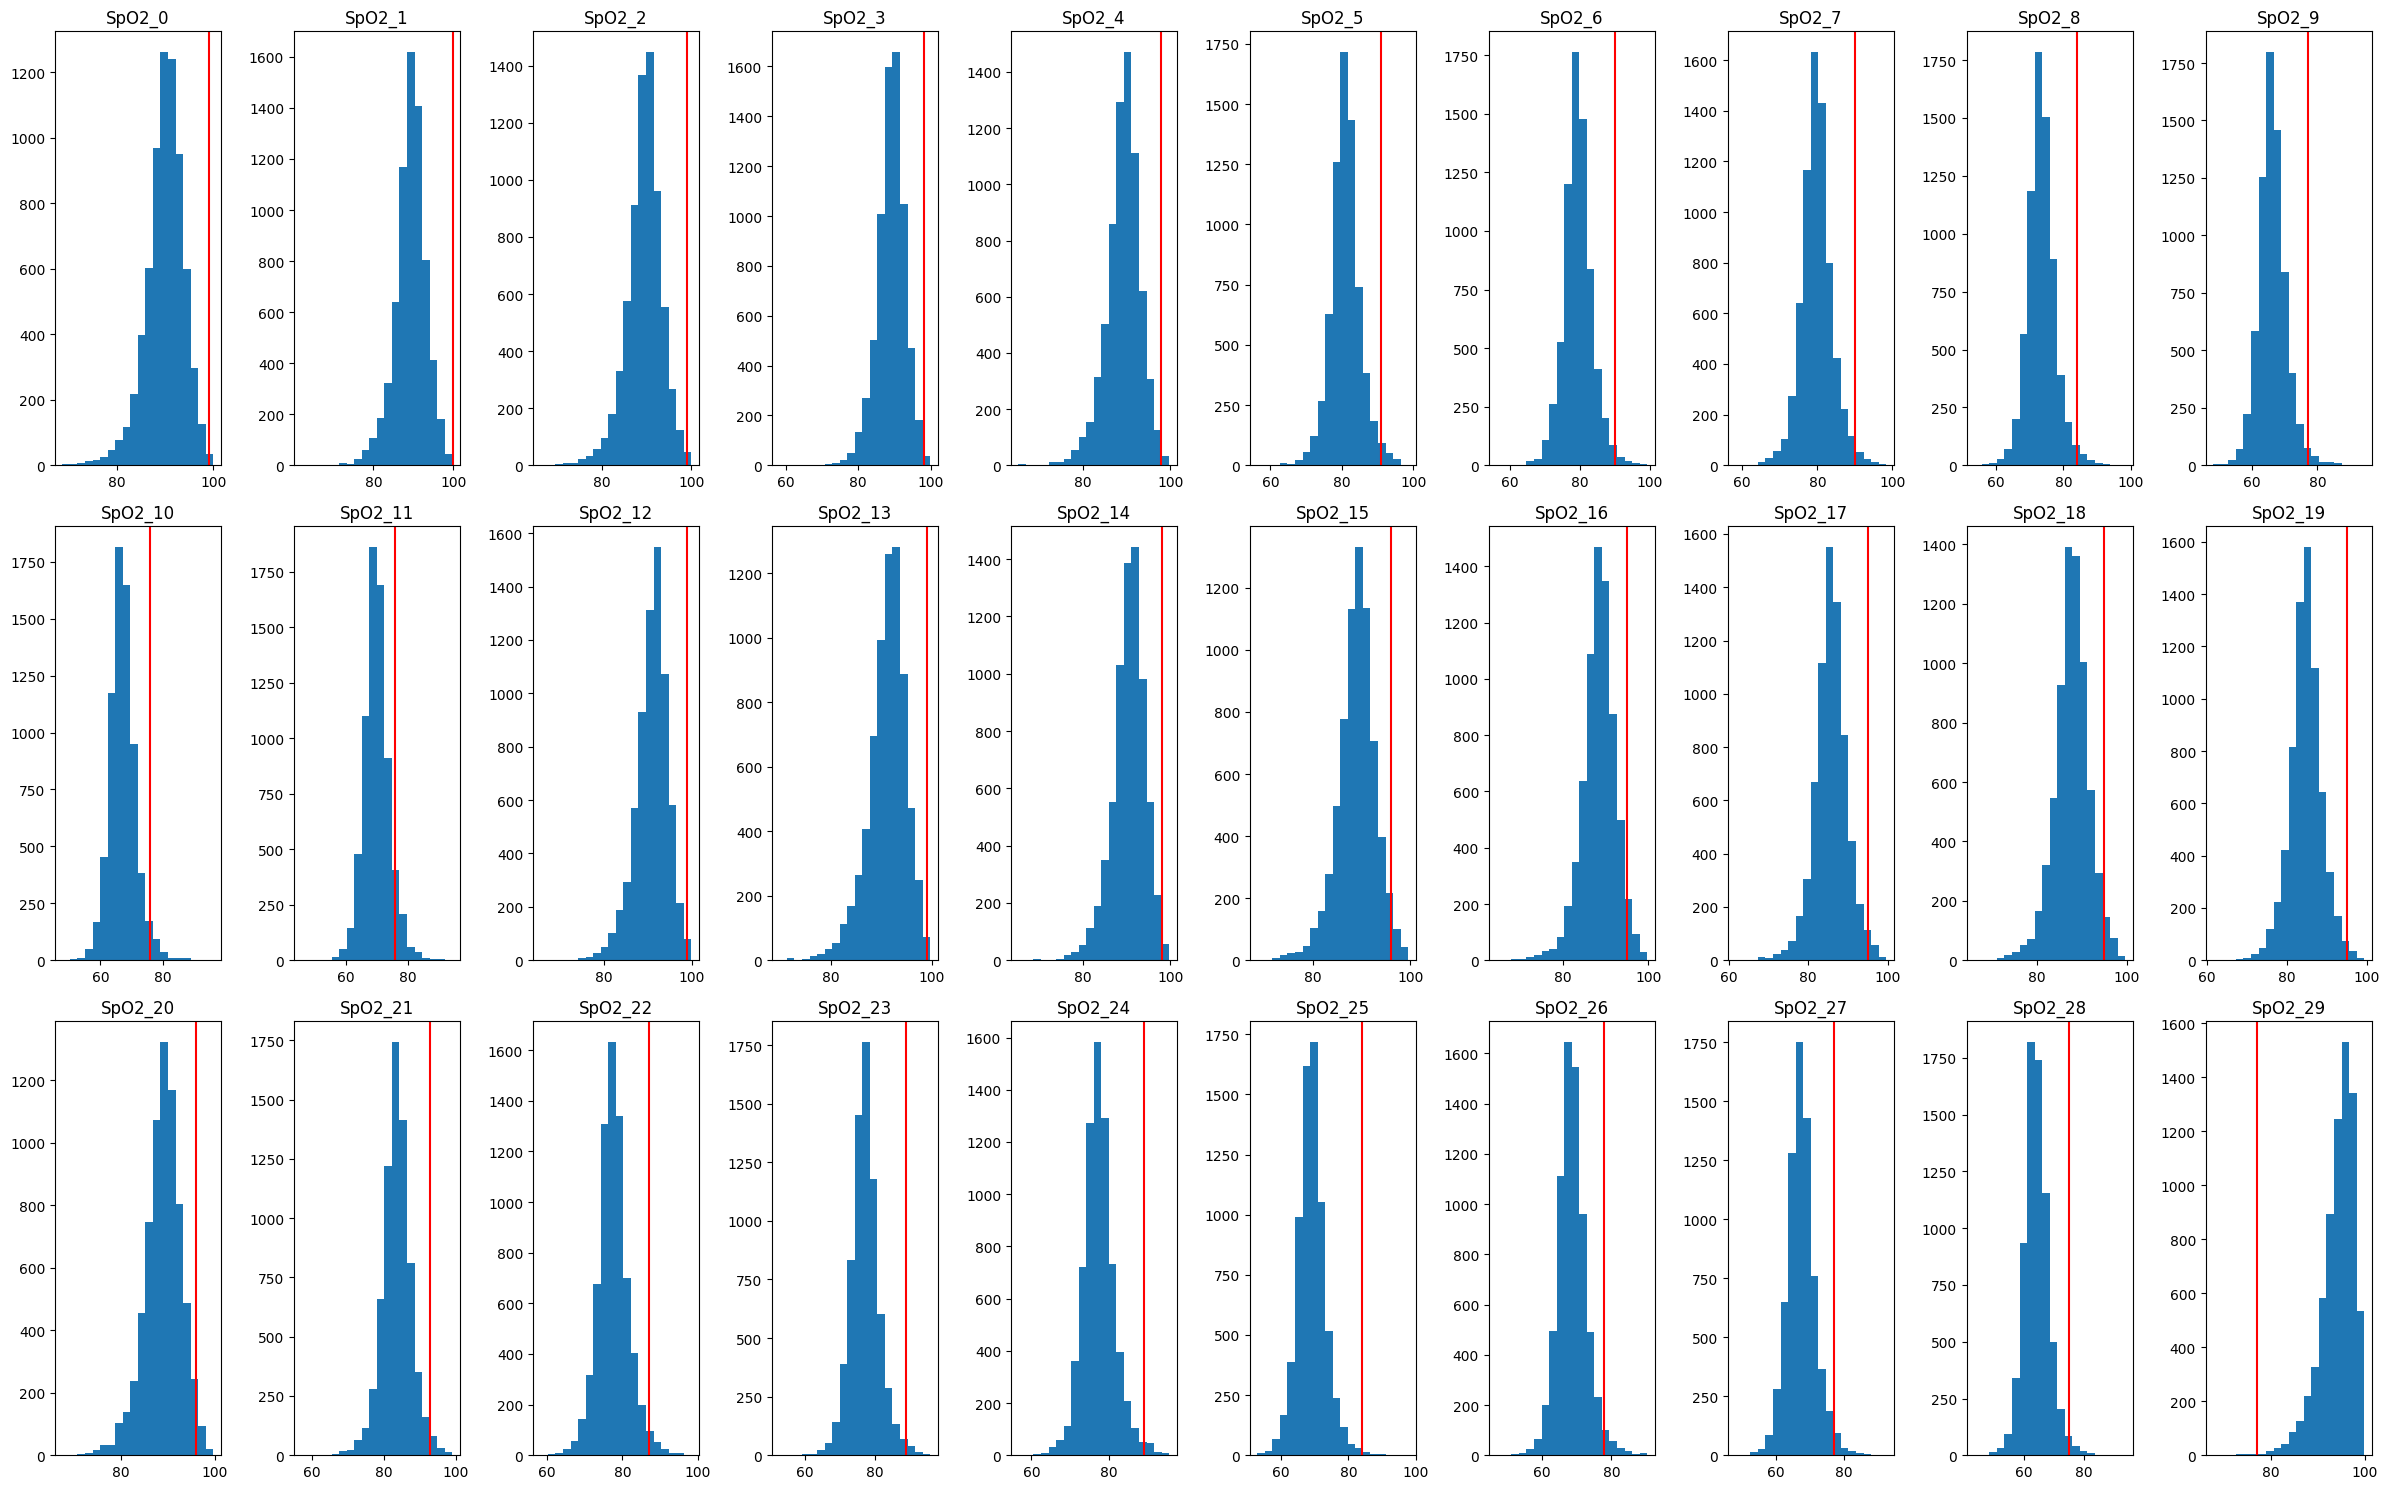

In [28]:
fig,axes = plt.subplots(3,10,figsize=(24,15))

axes = axes.flatten()
for i in range(30):
    axes[i].hist(flat_samples[:,i+5],bins=20)
    axes[i].axvline(spo2_200[i], color='red', label='Observed SPO2')
    axes[i].set_title(f"SpO2_{i}")
plt.tight_layout()
plt.show()


We can see that the estimated posterior probability distribution of the oximetry can predict the observed SpO2 is in the range of the possible value  but not really all the times the distribution is most of the time less than the observed value. It will confirm the Homework2 where the SpO2 is not very accurate. The frenquecies where the observed is correctly predict is very small

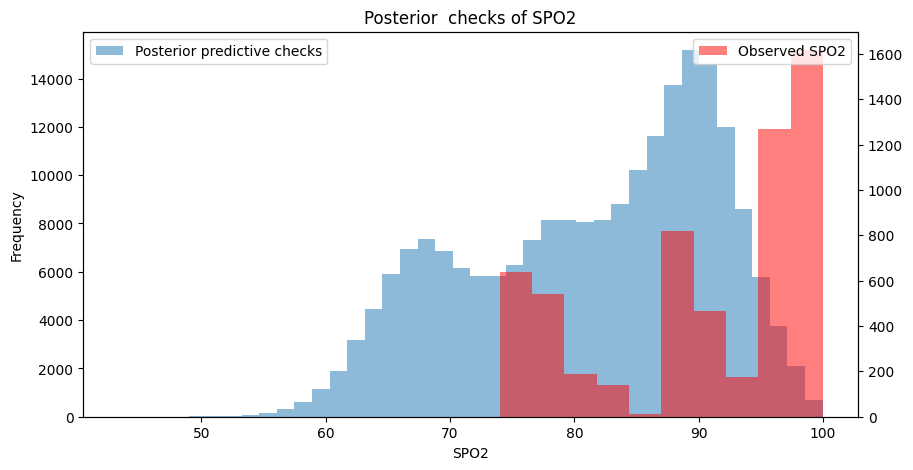

In [122]:
spo2_sampler = flat_samples[:,5:]
spo2_sampler = spo2_sampler.flatten()


fig = plt.figure(figsize=(10, 5))
ax = plt.axes()

ax.hist(spo2_sampler, bins=40, alpha=0.5, label='Posterior predictive checks')
ax2 = ax.twinx()
ax2.hist(spo2, color = 'r',alpha=0.5, label='Observed SPO2')
ax.set_xlabel('SPO2')
ax.set_ylabel('Frequency')
ax.set_title('Posterior  checks of SPO2')
ax.legend(loc ='upper left')
ax2.legend(loc='upper right')
plt.show()



With this graphics, we can confirm the previous statements above where it will say that the posterior predictive checks will reduce the observed values of the SpO2 and most of the time will give us a underestimate SpO2. Our model can't predict the posterior of SpO2 well

<div class="alert alert-success">
    
**Exercise**. Evaluate the posterior predictive distribution of $R_{1:T}$. Discuss the results.
        
</div>

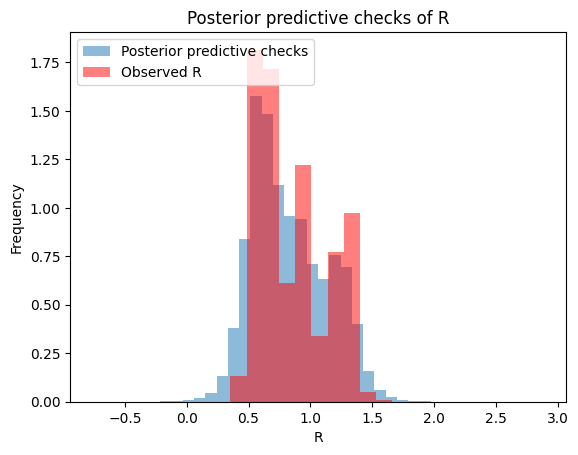

In [ ]:
thetas = flat_samples[:1000]

def pp(thetas):
    r = []
    for theta in thetas:
        r.append(sample_likelihood(theta, 1))
    return np.array(r)

def replicate(n_samples, thetas):
    data = []
    for _ in range(n_samples):
        data.append(pp(thetas))
    return np.array(data)

r_pp = replicate(40, thetas)
r_pp = r_pp.squeeze(axis=2)
r_pp = r_pp.reshape(40,-1)
fig = plt.figure()
axe = plt.axes()

axe.hist(r_pp.flatten(), bins=40, alpha=0.5, label='Posterior predictive checks',density=True)
axe.hist(r, color = 'r',alpha=0.5, label='Observed R', density=True)
axe.set_xlabel('R')
axe.set_ylabel('Frequency')
axe.set_title('Posterior predictive checks of R')
axe.legend(loc ='upper left')
plt.show()


When we are going to have the log_posterior we can regenerate with the parameters and the inputs the data to see if we have a good model $$p(x^\text{rep} | \{x\}) = \int p(x^\text{rep} | \theta) p(\theta | \{x\}) d\theta$$

We can see that even though the posterior distribution of SpO2 is bad in any case for the in any case we can generate the initial data quite faithfully 

<div class="alert alert-success">
    
**Exercise**. Evaluate the posterior predictive distributions of test quantities (statistics) of $R_{1:T}$. Discuss the results.
        
</div>

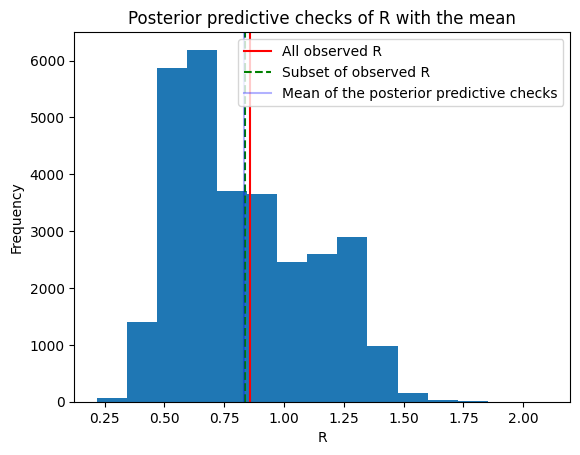

In [177]:

fig = plt.figure()
axe = plt.axes()

axe.hist(r_pp.mean(axis=0), bins=15)
axe.axvline(r.mean(), color="r", label = "All observed R")
axe.axvline(r_200.mean(), color="g", label ="Subset of observed R", linestyle='--')
axe.axvline(r_pp.mean(), color="b", label = "Mean of the posterior predictive checks", alpha = 0.3)

axe.set_xlabel('R')
axe.set_ylabel('Frequency')
axe.legend()
axe.set_title('Posterior predictive checks of R with the mean')
plt.show()



We can see that for the mean the posterior predictive checks are corrects not the best one but acceptable around the mean of. The average of all mean is at the mean of the posterior of R subset so we can say that for the mean this is good.

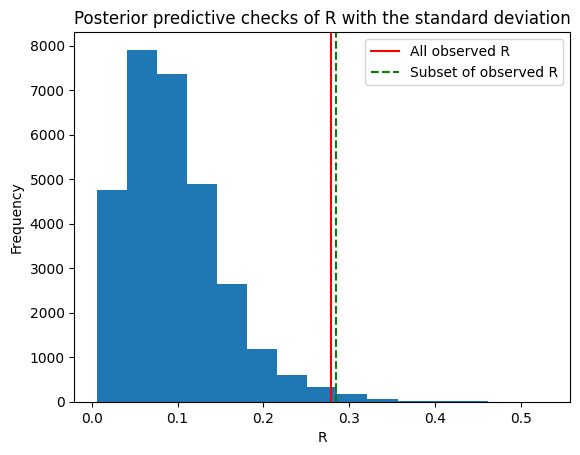

In [137]:
fig = plt.figure()
axe = plt.axes()

axe.hist(r_pp.std(axis=0), bins=15)
axe.axvline(r.std(), color="r", label = "All observed R")
axe.axvline(r_200.std(), color="g", label ="Subset of observed R", linestyle='--')

axe.set_xlabel('R')
axe.set_ylabel('Frequency')
axe.legend()
axe.set_title('Posterior predictive checks of R with the standard deviation')
plt.show()

For the standard deviation , we can't say this is good enough because the standard deviation of the observed values is larger than the posterior predictive one with a huge difference. We can explain that by the fact that the model can't have a big sigma_square so the data will be concentred 

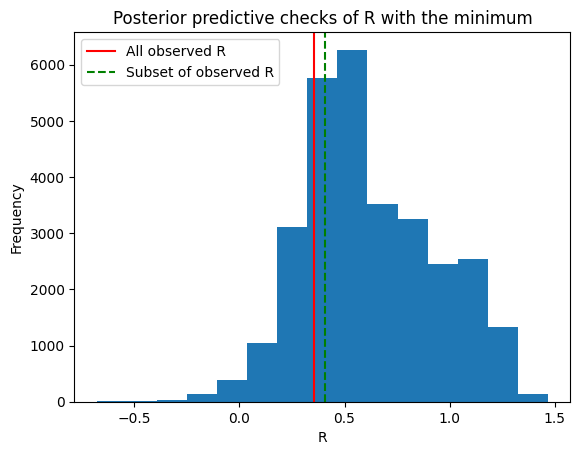

In [138]:
fig = plt.figure()
axe = plt.axes()

axe.hist(r_pp.min(axis=0), bins=15)
axe.axvline(r.min(), color="r", label = "All observed R")
axe.axvline(r_200.min(), color="g", label ="Subset of observed R", linestyle='--')

axe.set_xlabel('R')
axe.set_ylabel('Frequency')
axe.legend()
axe.set_title('Posterior predictive checks of R with the minimum')
plt.show()

We can see that our model can predict the minimum of the observed values but also can predict further values such as less than the minimum of the observed values or even negative values such as -0.5 and it will be not good because negative values are normally impossible to predict in the real so our model can be better

In [148]:
np.mean(r_pp.min(axis=0) >= r.min())

0.8066666666666666

Similar of the course when it will say "This suggests that the normal distribution is not adequate to model the data. Its tails are too light." 

<div class="alert alert-success">
    
**Exercise**. Evaluate the performance of the model quantitatively. Motivate your metric(s) and discuss.
        
</div>

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

r_rep = pp(thetas)
r_rep = r_rep.squeeze(axis=1)
r_rep_mean = r_rep.mean(axis=0)

T_obs = mean_absolute_error(r_200, r_rep_mean)
T_rep = [mean_absolute_error(r_200, r_rep_sim) for r_rep_sim in r_rep]
p_value = np.mean([T >= T_obs for T in T_rep])


print(f"MAE value : {T_obs}")
print(f"MSE value : {mean_squared_error(r_200, r_rep_mean)}")
print(f"p-value: {p_value}")




MAE value : 0.02199360535538595
MSE value : 0.0006793651179834702
p-value: 0.965


3 ways to be able to evaluate our model quantitatively by the mean absolute error or by the mean of the squares of errors or by using the p-value.

Let's compute the mean absolute error and the squares of errors between the observed values and the replicated values we can see that those values are near 0 so it means it is very good. It will means that our models predict correctly the R ratio.

MAE can be useful for comparing the same range of values. It can also be useful to see if the replicated are close to observed one or not
MSE can be useful for outliers in the data replicated so we don't have product anormal data.
p-value is useful to indicates is our results is under the null hypothesis or not. If the p-value is less than 0.05 then we will reject our model and try to find a better one.

In our context with the value of 0.965 we can't reject the null hypothesis, The MAE is low so the data are close of the observed one and with the low MSE there are not outliers values


<div class="alert alert-success">
    
**Exercise**. Criticize the model and propose an improvement. Implementing this improvement is not required.
        
</div>

With all the information available by doing this homework and the critize of our model. We can say that our models is good to predict the R ratio of the observed values but there are 2 big issues in this model. 

First, the sigma_square is near zero so we don't have to worry about it or change it into log normal to be able to use it. 

Second, the SpO2 that are predicted are very bad so we need to have a better estimation of them.

So one idea is to change the model by using a Beta distribution where alpha will be red or infrared and beta will be the other one(red if alpha is infrared, else infrared if alpha is red).By doing this, we can conserve the almost all the parameters except the sigma_square who will disappear. By doing this beta distribution we can assume that the range of R values will be positive and we can avoid the problem of the sigma_square